In [4]:
from numpy import pi, tan, sin, cos, arccos, radians
from gpkit import Model, Variable, units
from gpkit.tools import te_exp_minus1
import gpkit
gpkit.settings['latex_modelname'] = False


class SolarHALE(Model):
    def setup(self):
        constraints = []
        
    # Variable Setup
        #Structure Variables
        rho_skin = Variable('rho_{skin}',200, 'g/m^2', 'Wing Skin Density')
        W_cent = Variable('W_{cent}', 'lbf','Center aircraft weight')
        W_fix = Variable('W_{fix}',7,'lbf','fixed weight')
        #W_fuel = Variable('W_{fuel}','lbf','fuel weight')
        W_eng = Variable('W_{eng}',15,'lbf','engine weight') #needs better estimate
        W_fuse = Variable('W_{fuse}',20,'lbf','fuselage weight') #probably needs structural model/better estimate
        A_capcent = Variable('A_{capcent}','m**2','cap area at center')
        A_cap = Variable('A_{cap}','m**2','cap area') #currently assumes constant area
        V_cap = Variable('V_{cap}','m**3','cap volume')
        M_cap = Variable('M_{cap}','kg','cap mass')
        M_skin = Variable('M_{skin}','kg','skin mass')
        E_cap = Variable('E_cap', 2e7, 'psi','Youngs modulus cf') 
        M = Variable('M', 'N*m','center bending moment')
        d = Variable('d','m','Tip deflection') #need to add constraint
        h = Variable('h','m','Spar height') 
        sig = Variable('sig',475e6,'Pa','Cap stress') #http://www.performance-composites.com/carbonfibre/mechanicalproperties_2.asp
        F = Variable('F','N','load on wings')
        S_l = Variable('S_l','Pa','Shear load') #need to add constraint
        N = Variable('N',5,'-','Load factor') #load rating for max number of g's
        S = Variable('S', 'm^2', 'Wing reference area')
        P = Variable('P', 'N', 'cap load')
        c = Variable('c','m','wing chord') #assumes straight, untapered wing
        rho_cap = Variable('rho_cap',1.76, 'g/cm^3','density of cf')
        t_cap = Variable('t_cap',.028,'in','spar cap thickness') #arbitrarily placed based on available cf
        w_cap = Variable('w_cap','in','spar cap width')
        W = Variable('W', 'lbf', 'Aircraft weight')
        d_max = Variable('d_max',5,'m','max wing tip deflection')
        W_wing = Variable('W_wing','lbf','Total wing structural weight')
        
        #Aero Variables
        AR = Variable('AR', '-', 'aspect ratio') #constrained to limit plane size
        b = Variable('b', 'm', 'span')
        S_wet = Variable('S_wet','m^2','wetted area')
        t_c = Variable('t_c',0.1,'-','thickness ratio') #find better number
        C_dow = Variable('C_dow','-','zero lift wing drag')
        f_m = Variable('f_m',.996,'-','mach drag') #actual calculation not gp compatible
        Mach = Variable('Mach','-' ,'mach number')
        a = Variable('a',300,'m/s','speed of sound')
        F_tc = Variable('F_tc',1.28,'-','thickness factor') #calculated for t/c = 0.1
        C_dmin = Variable('C_dmin',.01,'-','min Cd') #find a number
        Cf = Variable("C_f", "-", "wing skin friction coefficient")
        e = Variable('e', 0.95, '-', "spanwise efficiency") #calculation not gp compatible
        mu = Variable(r'\mu', 1.5e-5, 'N*s/m^2', "dynamic viscosity")
        Re = Variable("Re", '-', "Reynolds number")
        Cd0 = Variable('C_{d0}', 0.01, '-', "non-wing drag coefficient")
        CLmax = Variable('C_{L-max}', 1.5, '-', 'maximum lift coefficient')  
        Kwing = Variable("K_{wing}", 1.3, "-", "wing form factor")
        CD = Variable('C_D', '-', 'Drag coefficient')
        CL = Variable('C_L', '-', 'Lift coefficient')
        V = Variable('V', 'm/s', 'Cruise velocity')
        V_min = Variable('V_{min}', 5,"m/s", "minimum flight velocity")
        rho = Variable(r'\rho',.2, 'kg/m^3','air density at altitude')
        
        #Breguet Variables
        #W_zfw = Variable('W_{zfw}', 'lbf', 'Zero fuel weight')
        wl = Variable('wl', 'lbf/ft^2', 'wing loading')
        z_bre = Variable("z_bre", "-", "breguet coefficient")
        h_fuel = Variable("h_{fuel}", 42e6, "J/kg", "heat of combustion")
        t = Variable('t', 5, 'days', 'time on station')
        
        #Propulsion
        eta_0 = Variable("\\eta_0", 0.2, "-", "overall efficiency")
        P_shaft = Variable('P_{shaft}', 'W', 'Shaft power')
        eta_prop = Variable(r'\eta_{prop}', 0.8, '-', 'Propulsive efficiency')
       
       #atmospheric
        g = Variable('g', 9.81, 'm/s^2', 'Gravitational acceleration')
        wind_fact = Variable('wind_fact',0.004,'1/s','wind altitude slope')
        wind_sl = Variable('wind_sl',12.485,'m/s','sea level wind')
        alt = Variable("alt", 15000,"ft", "Altitude")
        p_sl = Variable("p_{sl}", 101325, "Pa", "Pressure at sea level")
        T_sl = Variable("T_{sl}", 288.15, "K", "Temperature at sea level")
        L_atm = Variable("L_{atm}", 0.0065, "K/m", "Temperature lapse rate")
        #T_atm = Variable("T_{atm}", "K", "air temperature")
        M_atm = Variable("M_{atm}", 0.0289644, "kg/mol", "Molar mass of dry air")
        R_atm = Variable("R_{atm}", 8.31447, "J/mol/K")
        
        W_batt = Variable('W_{batt}', 'lbf', 'Battery weight')
        W_solar = Variable('W_{solar}', 'lbf', 'Solar panel weight')
       
       
#constraints
       
    # Propulsion model
        constraints.extend([P_shaft == V*W*CD/CL/eta_prop,   # eta*P = D*V
                            W == 0.5*rho*V**2*CL*S,
                            #V_min >= wind_fact*alt+wind_sl,
                            V >= V_min])
        
    # structures model
        constraints.extend([M_skin == rho_skin*2*S,
                            F ==W_cent*N,
                            c == S/b,
                            M == b*F/8,
                            P >= M/h,
                            A_capcent >= P/sig,
                            V_cap >= A_capcent*b/3,
                            M_cap == rho_cap*V_cap,
                            b == (AR*S)**0.5,
                            h <= t_c*c,
                            W_cent >= W_fix + W_fuse + W_solar,
                            W_wing >= M_skin*g+M_cap*g,
                            W >= W_cent + W_wing + W_batt, #1.2 factor to account for tail weight
                           # W_zfw >= W_fix +W_eng+W_fuse+M_skin*g + M_cap*g,
                            w_cap == A_capcent/t_cap,
                            wl ==W/S,
                            d == b**2*sig/(4*E_cap*h),
                            d <=d_max])
        
    # Aero Model
        constraints.extend([S_wet >=2*(1+t_c/2)*b*c,
                            Mach == V/a,
                            #F_tc >= 1+2.7*t_c+100*(t_c)**4,
                            C_dow == Cf*F_tc*(S_wet/S)*(C_dmin/.004)**0.4,
                            Cf >= 0.074/Re**0.2,
                            Re == rho*V/mu*(S/AR)**0.5,
                            CD >= C_dow + CL**2/(pi*e*AR)+Cd0, #+ 2*Cf*Kwing
                            CL <= CLmax])
        
    # Breguet
            
#         constraints.extend([z_bre >= g*t*V*CD/(h_fuel*eta_0*CL),
#                             W_fuel/W_zfw >= te_exp_minus1(z_bre,3)])
                           
        
        
    # Atmosphere model

        TH = (g*M_atm/R_atm/L_atm).value.magnitude  # dimensionless
        #constraints.extend([alt <= 20000*units.m])  # Model valid to top of troposphere
                            #T_sl >= T_atm + L_atm*h])    # Temp decreases w/ altitude
                           # rho <= p_sl*T_atm**(TH-1)*M_atm/R_atm/(T_sl**TH)])  # http://en.wikipedia.org/wiki/Density_of_air#Altitude
        
    # station keeping requirement
        footprint = Variable("d_{footprint}", 100, 'km', "station keeping footprint diameter")
        lu = Variable(r"\theta_{look-up}", 5, '-', "look up angle")
        R_earth = Variable("R_{earth}", 6371, "km", "Radius of earth")
        tan_lu = lu*pi/180. + (lu*pi/180.)**3/3.  # Taylor series expansion
        # approximate earth curvature penalty as distance^2/(2*Re)
        #constraints.extend([alt >= tan_lu*0.5*footprint + footprint**2/8./R_earth])
        
        
        
        # Solar Weight model
        E_batt = Variable('E_{batt}', 'J', 'Battery energy')
        rho_solar = Variable(r'\rho_{solar}', 25, 'mg/cm^2', 'Solar cell area density')
        h_batt = Variable('h_{batt}', 500, 'W*hr/kg', 'Battery energy density') #solar impulse number Li ion
            
        # Solar Power model
        DaysAfterVernal = Variable('DaysAfterVernal',270,'days','Days after vernal equinox')
        latitude = Variable('latitude',45,'deg','latitude location')
        theta = 23.5*sin(2*pi*270/(365.25))+90
        theta_sun = Variable('theta_sun',theta,'deg','degrees north of the south pole')
        theta2 = 137*cos(radians(45-(theta-90)))
        solar_c = Variable('solar_c',theta2,'mW/cm^2', 'solar constant for a given day')
        theta3 = (24/pi)*arccos(-tan(radians(theta-90))*tan(radians(45)))
        t_day = Variable('t_{day}', theta3,'hr', 'Daylight span')
        eta_solar = Variable(r'\eta_{solar}', 0.18, '-', 'Solar cell efficiency') #0.09 for thin film
        eta_charge = Variable(r'\eta_{charge}', 0.95, '-', 'Battery charging efficiency')
        eta_discharge = Variable(r'\eta_{discharge}', 0.95, '-', 'Battery discharging efficiency')
        solar_day_charge = Variable('solar_day_charge','J','solar day charge')
        
        sin_days = Variable('sin_days','-','sin of days expansion')
        cos_lattheta = Variable('cos_lattheta','-','cos of difference between lat & theta')
        tan_thetasun = Variable('tan_thetasun', '-','tan of sun angle')
        tan_lat = Variable('tan_lat', '-','tan of lat')
        
        
        PS_irr = Variable('(P/S)_{irr}', 1000*0.5, 'W/m^2', 'Average daytime solar irradiance')
        P_oper = Variable('P_{oper}', 'W', 'Aircraft operating power')
        P_charge = Variable('P_{charge}', 'W', 'Battery charging power')
        P_acc = Variable('P_{acc}', 11, 'W', 'Accessory power draw')

        
        t_night = Variable('t_{night}', 'hr', 'Night span')
        
        constraints.extend([t_night +t_day <= 24*units.hour,
                            t_night>=1*units.hour,
                            solar_day_charge == theta_sun*S*t_day*eta_solar*solar_c/pi,
                            W_solar == rho_solar*S*g,
                            P_oper >= P_shaft + P_acc,
                            solar_day_charge >=P_oper*24*units.hr,
                            W_batt == solar_day_charge/h_batt*g*.75])  
        
#         constraints.extend([sin_days + (2*pi*DaysAfterVernal/(365.25*units.days))**3/6 == 2*pi*DaysAfterVernal/(365.25*units.days),
#                             cos_lattheta + (latitude-theta_sun)^2/2 == 1,
#                             tan_thetasun = theta_sun*pi/180. + (theta_sun*pi/180.)**3/3.,
#                             theta_sun == 23.5*sin_days])
        
        
#         constraints.extend([PS_irr*eta_solar*S >= P_oper + P_charge,
#                             P_oper >= P_shaft + P_acc,
#                             P_charge >= E_batt/(t_day*eta_charge),
#                             t_day + t_night <= 24*units.hr,
#                             E_batt >= P_oper*t_night/eta_discharge])


        objective = W
    
        
        return objective, constraints

m = SolarHALE()
m.solve('cvxopt')

Using solver 'cvxopt'
Solving for 32 variables.
Solving took 0.0435 seconds.

Cost
----
 66.4 [lbf] 

Free Variables
--------------
              AR : 27.69                  aspect ratio                  
     A_{capcent} : 5.795e-05  [m**2]      cap area at center            
             C_D : 0.06525                Drag coefficient              
             C_L : 1.5                    Lift coefficient              
           C_dow : 0.02803                zero lift wing drag           
             C_f : 0.007229               wing skin friction coefficient
               F : 795.1      [N]         load on wings                 
               M : 2084       [N*m]       center bending moment         
         M_{cap} : 0.7127     [kg]        cap mass                      
        M_{skin} : 6.348      [kg]        skin mass                     
            Mach : 0.03713                mach number                   
               P : 2.753e+04  [N]         cap load               

{'constants': {\rho_{solar}_SolarHALE3: array(25),
  h_{batt}_SolarHALE3: array(500),
  theta_sun_SolarHALE3: array(66.55388802131225),
  solar_c_SolarHALE3: array(50.330531726421526),
  t_{day}_SolarHALE3: array(8.57303314783957),
  \eta_{solar}_SolarHALE3: array(0.18),
  P_{acc}_SolarHALE3: array(11),
  C_{d0}_SolarHALE3: array(0.01),
  sig_SolarHALE3: array(475000000.0),
  rho_{skin}_SolarHALE3: array(200),
  W_{fix}_SolarHALE3: array(7),
  d_max_SolarHALE3: array(5),
  e_SolarHALE3: array(0.95),
  t_cap_SolarHALE3: array(0.028),
  C_{L-max}_SolarHALE3: array(1.5),
  E_cap_SolarHALE3: array(20000000.0),
  W_{fuse}_SolarHALE3: array(20),
  F_tc_SolarHALE3: array(1.28),
  t_c_SolarHALE3: array(0.1),
  a_SolarHALE3: array(300),
  C_dmin_SolarHALE3: array(0.01),
  \mu_SolarHALE3: array(1.5e-05),
  N_SolarHALE3: array(5),
  rho_cap_SolarHALE3: array(1.76),
  g_SolarHALE3: array(9.81),
  \eta_{prop}_SolarHALE3: array(0.8),
  V_{min}_SolarHALE3: array(5),
  \rho_SolarHALE3: array(0.2)},
 '

In [67]:
import numpy as np
m.substitutions.update({"d_{footprint}": ('sweep', np.linspace(100, 300, 13)),
                        "h_{batt}": ('sweep', np.linspace(150, 250, 13))})
sol = m.solve(solver="mosek", verbosity=0, skipsweepfailures=True)

ImportError: Could not load MOSEK library: ImportError('No module named lib',)

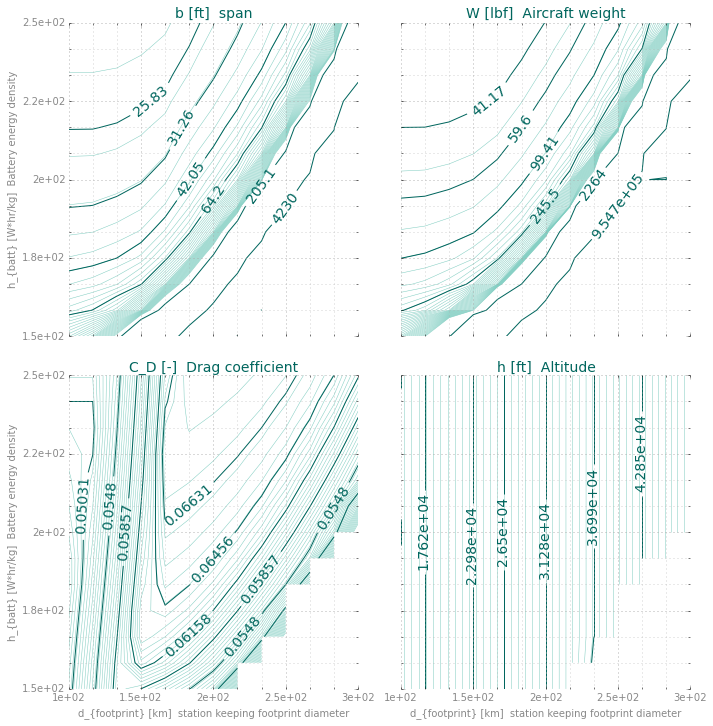

In [27]:
%matplotlib inline
from gpkit.interactive.plotting import contour_array
_ = contour_array(m, "d_{footprint}", "h_{batt}", ["b", "W", "C_D", "h"])